# Generating RMO and CSPS example images for section 3.6

In [12]:
from math import pi

import numpy as np
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from utils import targetToTensor, multi_logical_or, create_relational_kernel
from datasets.clostob.clostob_dataset import CloStObDataset
from spatial_loss import SpatialPriorErrorSegmentation, RelationalMapOverlap

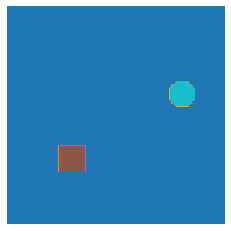

In [56]:
image_dimensions = (160,160)

# Creating image
image = np.zeros(image_dimensions)

# # Adding object A (the triangle)
# triangle = np.zeros((20,20))
# for x, row in enumerate(triangle):
#     for y, point in enumerate(row):
#         if x >= y:
#             triangle[x, y] = 1
# image[102:122, 38:58] = triangle*1

# Adding object A (the square)
image[102:122, 38:58] = 1

# Adding object B (the circle)
circle = np.zeros((20,20))
for x, row in enumerate(circle):
    for y, point in enumerate(row):
        i, j = x-10, y-10
        if (i**2 + j**2 <100):
            circle[x,y] = 1
image[54:74, 118:138] = circle*2

plt.imshow(image, cmap="tab10")
plt.axis("off")
#plt.show()
plt.savefig("example_image.png", bbox_inches="tight")

image = torch.tensor(image)


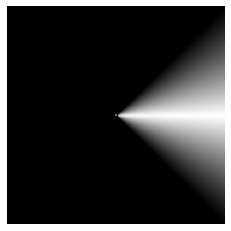

In [57]:
# assembling the relational kernel
tau = create_relational_kernel(80, pi, 20, pi/2)
plt.imshow(tau, cmap="gray")
plt.axis("off")
#plt.show()
plt.savefig("relational_kernel.png", bbox_inches="tight")

tensor(1.)


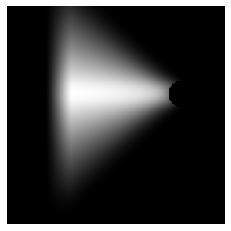

In [63]:
# making the relational map
source_labelmap = (image==2).to(dtype=torch.float)
phi = torch.nn.functional.conv2d(source_labelmap.view(1,1, *image_dimensions), tau.view(1,1, *tau.size()), padding="same")[0,0]
phi[source_labelmap == 1] = 0  # subtracting the source
phi = torch.div((phi - phi.min()), (phi.max() - phi.min()))

plt.imshow(phi, cmap="gray")
plt.axis("off")
#plt.show()
plt.savefig("relational_map.png", bbox_inches="tight")

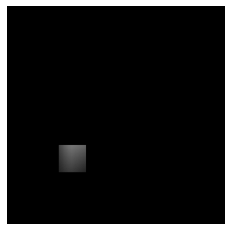

In [70]:
# intersecting map with target
target_labelmap = (image==1).to(dtype=torch.float)
psi = phi * target_labelmap

plt.imshow(psi, cmap="gray", vmax=1)
plt.axis("off")
#plt.show()
plt.savefig("intersected_map.png", bbox_inches="tight")

In [71]:
# Computing RMO
sum_psi = torch.sum(psi)
sum_target = torch.sum(target_labelmap)
rms = torch.div(sum_psi, sum_target)
print("Sum Psi", sum_psi.item())
print("Sum target", sum_target.item())
print("RMO:", rms.item())

Sum Psi 115.96726989746094
Sum target 400.0
RMO: 0.2899181842803955


## Relational Kernels for T CSO

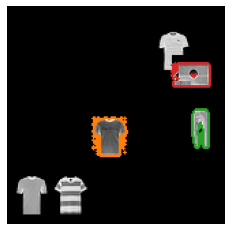

In [28]:
image_dimensions = [160,160]
fg_classes = [0, 1, 8]
base_fg_positions = [(0.65, 0.3), (0.65, 0.7), (0.35, 0.7)]
position_translation=0.5
position_noise=0
bg_bboxes = (0.4, 0.0, 0.9, 0.5)
experimental_config = {"label": "T" + "_hard", "bg_classes": [0], "bg_amount": 3, "position_noise": 0.1, "bg_bboxes": None}
sample = CloStObDataset(base_dataset_name="fashion",
                                image_dimensions=image_dimensions,
                                size=1,
                                fg_classes=fg_classes,
                                fg_positions=base_fg_positions,
                                position_translation=position_translation,
                                position_noise=experimental_config["position_noise"],
                                bg_classes=experimental_config["bg_classes"], # Background class from config
                                bg_amount=experimental_config["bg_amount"],
                                bg_bboxes=experimental_config["bg_bboxes"],
                                fine_segment=True,
                                flattened=False,
                                lazy_load=False,
                                start_seed=1)[0]
sample_image, sample_labelmap = sample["image"], sample["labelmap"]

sample_image /= 255
for label, color in zip(range(1,4), [plt.get_cmap("tab10")(1)[:3], plt.get_cmap("tab10")(2)[:3], plt.get_cmap("tab10")(3)[:3]]):
            sample_image = mark_boundaries(sample_image, sample_labelmap==label, color=color, mode="thick", background_label=0)

plt.imshow(sample_image, cmap="gray")
plt.axis("off")
#plt.show()
plt.savefig("t_cso_relational_map_image.png", bbox_inches="tight")

In [6]:
slack = 14
map_relations = [(2, 1, create_relational_kernel(distance=0.4*image_dimensions[0], angle=pi, distance_slack=slack)),
                            (1, 2, create_relational_kernel(distance=0.4*image_dimensions[0], angle=pi+pi, distance_slack=slack)),
                            (3, 2, create_relational_kernel(distance=0.3*image_dimensions[0], angle=pi/2, distance_slack=slack)),
                            (2, 3, create_relational_kernel(distance=0.3*image_dimensions[0], angle=pi/2 + pi, distance_slack=slack)),
                            (3, 1, create_relational_kernel(distance=0.5*image_dimensions[0], angle=(7/6)*pi, distance_slack=slack)),
                            (1, 3, create_relational_kernel(distance=0.5*image_dimensions[0], angle=(7/6)*pi - pi, distance_slack=slack))] 

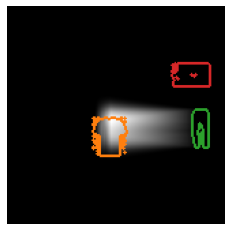

In [29]:
# making the relational map
source_labelmap = (torch.tensor(sample_labelmap)==2).to(dtype=torch.float)
tau = map_relations[0][2]
phi = torch.nn.functional.conv2d(source_labelmap.view(1,1, *image_dimensions), tau.view(1,1, *tau.size()), padding="same")[0,0]
phi[source_labelmap == 1] = 0  # subtracting the source
phi = torch.div((phi - phi.min()), (phi.max() - phi.min()))

display_phi = phi.numpy()
for label, color in zip(range(1,4), [plt.get_cmap("tab10")(1)[:3], plt.get_cmap("tab10")(2)[:3], plt.get_cmap("tab10")(3)[:3]]):
            display_phi = mark_boundaries(display_phi, sample_labelmap==label, color=color, mode="thick", background_label=0)

plt.imshow(display_phi, cmap="gray")
plt.axis("off")
#plt.show()
plt.savefig("t_cso_21_relational_map.png", bbox_inches="tight")

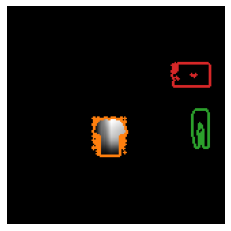

In [30]:
# intersecting map with target
target_labelmap = (torch.tensor(sample_labelmap)==1).to(dtype=torch.float)
psi = phi * target_labelmap

for label, color in zip(range(1,4), [plt.get_cmap("tab10")(1)[:3], plt.get_cmap("tab10")(2)[:3], plt.get_cmap("tab10")(3)[:3]]):
            psi = mark_boundaries(psi, sample_labelmap==label, color=color, mode="thick", background_label=0)

plt.imshow(psi, cmap="gray", vmax=1)
plt.axis("off")
#plt.show()
plt.savefig("t_cso_21_intersected_map.png", bbox_inches="tight")

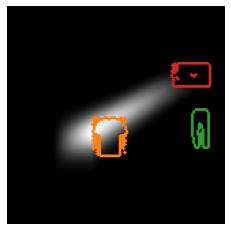

In [32]:
# making the relational map
source_labelmap = (torch.tensor(sample_labelmap)==3).to(dtype=torch.float)
tau = map_relations[4][2]
phi = torch.nn.functional.conv2d(source_labelmap.view(1,1, *image_dimensions), tau.view(1,1, *tau.size()), padding="same")[0,0]
phi[source_labelmap == 1] = 0  # subtracting the source
phi = torch.div((phi - phi.min()), (phi.max() - phi.min()))

display_phi = phi.numpy()
for label, color in zip(range(1,4), [plt.get_cmap("tab10")(1)[:3], plt.get_cmap("tab10")(2)[:3], plt.get_cmap("tab10")(3)[:3]]):
            display_phi = mark_boundaries(display_phi, sample_labelmap==label, color=color, mode="thick", background_label=0)

plt.imshow(display_phi, cmap="gray")
plt.axis("off")
#plt.show()
plt.savefig("t_cso_31_relational_map.png", bbox_inches="tight")

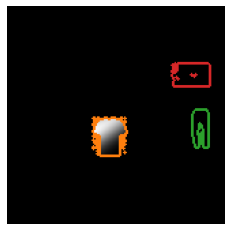

In [33]:
# intersecting map with target
target_labelmap = (torch.tensor(sample_labelmap)==1).to(dtype=torch.float)
psi = phi * target_labelmap

for label, color in zip(range(1,4), [plt.get_cmap("tab10")(1)[:3], plt.get_cmap("tab10")(2)[:3], plt.get_cmap("tab10")(3)[:3]]):
            psi = mark_boundaries(psi, sample_labelmap==label, color=color, mode="thick", background_label=0)

plt.imshow(psi, cmap="gray", vmax=1)
plt.axis("off")
#plt.show()
plt.savefig("t_cso_31_intersected_map.png", bbox_inches="tight")

In [5]:
for i in range(6):
    kernel = map_relations[i][2]
    figsize = ((kernel.shape[0]/175)*5)

    plt.figure(figsize=[figsize, figsize])
    plt.imshow(kernel, cmap="gray")
    plt.xticks([0, kernel.shape[0]])
    plt.yticks([0, kernel.shape[1]])
    plt.savefig("kernel{}.png".format(i), bbox_inched="tight")
    plt.clf()

/tmp/ipykernel_121050/4280702367.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inched" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("kernel{}.png".format(i), bbox_inched="tight")


<Figure size 294.171x294.171 with 0 Axes>

<Figure size 294.171x294.171 with 0 Axes>

<Figure size 228.343x228.343 with 0 Axes>

<Figure size 228.343x228.343 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>